# Plotting using PySpark

If running outside Watson Studio, this should work as well. In case you are running in an Apache Spark context outside Watson Studio, please remove the Apache Spark setup in the first few cells of the notebook.

## Setting up Spark
<hr>

In [1]:
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown('# <span style="color:red">'+string+'</span>'))

if ('sc' in locals() or 'sc' in globals()):
    printmd('<<<<<!!!!! It seems that you are running in a IBM Watson Studio Apache Spark Notebook. Please run it in an IBM Watson Studio Default Runtime (without Apache Spark) !!!!!>>>>>')

In [3]:
!pip install pyspark==2.4.5

     |████████████████████████████████| 217.8MB 144kB/s  eta 0:00:01    |███████▏                        | 48.7MB 41.1MB/s eta 0:00:05     |███████████                     | 74.9MB 39.6MB/s eta 0:00:04        | 82.9MB 39.1MB/s eta 0:00:04     |████████████████▍               | 111.3MB 9.7MB/s eta 0:00:11     |███████████████████▍            | 132.3MB 9.4MB/s eta 0:00:10     | 141.3MB 9.4MB/s eta 0:00:09�█████████▊          | 147.7MB 9.4MB/s eta 0:00:08     |███████████████████████         | 156.7MB 2.2MB/s eta 0:00:28��██████████████▉   | 196.5MB 34.5MB/s eta 0:00:01
     |████████████████████████████████| 204kB 15.0MB/s eta 0:00:01
  Stored in directory: /home/dsxuser/.cache/pip/wheels/bf/db/04/61d66a5939364e756eb1c1be4ec5bdce6e04047fc7929a3c3c
Successfully built pyspark


In [4]:
try:
    from pyspark import SparkContext, SparkConf
    from pyspark.sql import SparkSession
except ImportError as e:
    printmd('<<<<<!!!!! Please restart your kernel after installing Apache Spark !!!!!>>>>>')

In [5]:
sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))

spark = SparkSession \
    .builder \
    .getOrCreate()

## Loading data

In [6]:
# downloading data
!wget https://github.com/IBM/coursera/blob/master/coursera_ds/washing.parquet?raw=true
!mv washing.parquet?raw=true washing.parquet

--2020-06-26 04:00:15--  https://github.com/IBM/coursera/blob/master/coursera_ds/washing.parquet?raw=true
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/IBM/skillsnetwork/blob/master/coursera_ds/washing.parquet?raw=true [following]
--2020-06-26 04:00:15--  https://github.com/IBM/skillsnetwork/blob/master/coursera_ds/washing.parquet?raw=true
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/IBM/skillsnetwork/raw/master/coursera_ds/washing.parquet [following]
--2020-06-26 04:00:15--  https://github.com/IBM/skillsnetwork/raw/master/coursera_ds/washing.parquet
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/IBM/skillsnetwork/master/coursera_ds/washing.parquet [fo

In [7]:
# loading data
df = spark.read.parquet('washing.parquet')
# number of rows
df.count()

2058

## Registering the data frame in the ApacheSparkSQL catalog

In [8]:
# register the data frame in the ApacheSparkSQL catalog so that we can query it using SQL
df.createOrReplaceTempView("washing")
spark.sql("SELECT * FROM washing").show()

+--------------------+--------------------+-----+--------+----------+---------+--------+-----+-----------+-------------+-------+
|                 _id|                _rev|count|flowrate|fluidlevel|frequency|hardness|speed|temperature|           ts|voltage|
+--------------------+--------------------+-----+--------+----------+---------+--------+-----+-----------+-------------+-------+
|0d86485d0f88d1f9d...|1-57940679fb8a713...|    4|      11|acceptable|     null|      77| null|        100|1547808723923|   null|
|0d86485d0f88d1f9d...|1-15ff3a0b304d789...|    2|    null|      null|     null|    null| 1046|       null|1547808729917|   null|
|0d86485d0f88d1f9d...|1-97c2742b68c7b07...|    4|    null|      null|       71|    null| null|       null|1547808731918|    236|
|0d86485d0f88d1f9d...|1-eefb903dbe45746...|   19|      11|acceptable|     null|      75| null|         86|1547808738999|   null|
|0d86485d0f88d1f9d...|1-5f68b4c72813c25...|    7|    null|      null|       75|    null| null|   

## Visualize Voltage 
- using a box plot to get an idea on the value distribution of this parameter. First, create a python list. Make sure you use the sample function in order to not blast your spark driver or plotting library.

In [9]:
result = spark.sql("select voltage from washing where voltage is not null")
result_array = result.rdd.map(lambda row : row.voltage).sample(False,0.1).collect()

#just print the 1st 15 elements
result_array[:15]

[236, 225, 223, 233, 235, 232, 235, 231, 222, 223, 232, 239, 229, 229, 224]

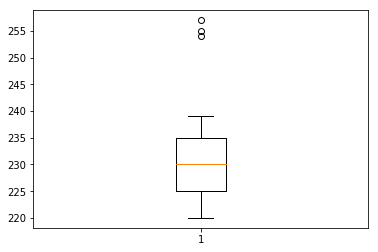

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.boxplot(result_array)
plt.show()

- Since we are dealing with time series data we want to make use of the time dimension as well. The least complex plots are run charts where the time domain (dimension) is represented at the horizontal x-axis and the y-axis shows the actual sensor value. Let's do this for voltage as well.

In [11]:
# sql query to get all ts, voltage vaues from washing
result = spark.sql("select voltage,ts from washing where voltage is not null order by ts asc")

# converting data frame to rdd and removing "Row(values)" from each row to leave just "values"
result_rdd = result.rdd.sample(False,0.1).map(lambda row : (row.ts,row.voltage))

# collecting ts for volatages from result_rdd
result_array_ts = result_rdd.map(lambda ts_voltage: ts_voltage[0]).collect()

# collecting voltages from result_rdd
result_array_voltage = result_rdd.map(lambda ts_voltage: ts_voltage[1]).collect()

# checking ts and voltage values
print(result_array_ts[:15])
print(result_array_voltage[:15])

[1547808737926, 1547808767938, 1547808776948, 1547808794957, 1547808800960, 1547808858035, 1547808864037, 1547808876043, 1547808891076, 1547808936120, 1547808945126, 1547808948129, 1547808984163, 1547809014196, 1547809035209]
[234, 224, 235, 224, 226, 228, 235, 221, 220, 234, 230, 236, 229, 255, 222]


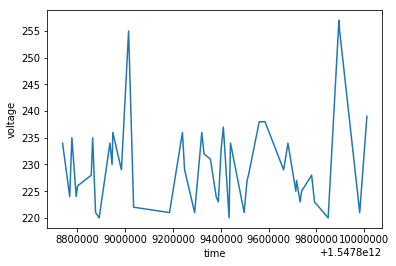

In [12]:
# plotting voltage values against ts
plt.plot(result_array_ts,result_array_voltage)
plt.xlabel("time")
plt.ylabel("voltage")
plt.show()

In [13]:
# checking the min and max values of ts
spark.sql("select min(ts),max(ts) from washing").show()

+-------------+-------------+
|      min(ts)|      max(ts)|
+-------------+-------------+
|1547808720911|1547810064867|
+-------------+-------------+



- Repeating the previous steps but only show data for an hour. 
- We've found out the low and high boundary of data available and we know that "ts" stand for "timestamp". 
- Timestamp are the number of millisecons passed since the 1st of Jan. 1970. You can also use an online tool like http://www.epochconverter.com/ to convert these. But for now just an interval of 60 minutes (10006060)=3600000 within the range above (note that we have removed the sample function because the data set is already reduced)

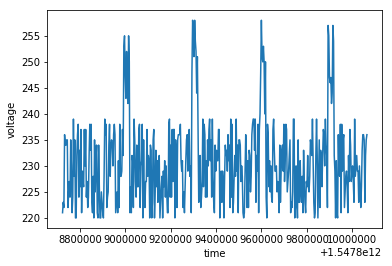

In [14]:
# sql query
result = spark.sql(
"""
select voltage,ts from washing 
    where voltage is not null and 
    ts > 1547808720911 and
    ts <= 1547810064867+3600000
    order by ts asc
""")

# converting query results to rdd and obtaining ts and voltage arrays
result_rdd = result.rdd.map(lambda row : (row.ts,row.voltage))
result_array_ts = result_rdd.map(lambda ts_voltage: ts_voltage[0]).collect()
result_array_voltage = result_rdd.map(lambda ts_voltage: ts_voltage[1]).collect()

# plotting voltage vs. ts
plt.plot(result_array_ts,result_array_voltage)
plt.xlabel("time")
plt.ylabel("voltage")
plt.show()

## Visualising hardness, flowrate and temperature together

In [15]:
# sql query
result_df = spark.sql("""
select hardness,temperature,flowrate from washing
    where hardness is not null and 
    temperature is not null and 
    flowrate is not null
""")

# converting query results to rdd and obtaining hardness, flowrate and temperature arrays
result_rdd = result_df.rdd.sample(False,0.1).map(lambda row : (row.hardness,row.temperature,row.flowrate))
result_array_hardness = result_rdd.map(lambda hardness_temperature_flowrate: hardness_temperature_flowrate[0]).collect()
result_array_temperature = result_rdd.map(lambda hardness_temperature_flowrate: hardness_temperature_flowrate[1]).collect()
result_array_flowrate = result_rdd.map(lambda hardness_temperature_flowrate: hardness_temperature_flowrate[2]).collect()

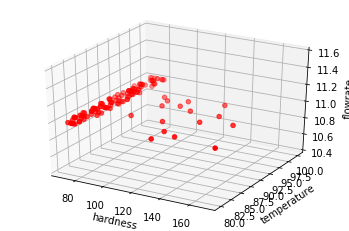

In [16]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(result_array_hardness,result_array_temperature,result_array_flowrate, c='r', marker='o')

ax.set_xlabel('hardness')
ax.set_ylabel('temperature')
ax.set_zlabel('flowrate')

plt.show()

You will notice that the individual points resemble in some sort of plane. But this is not a surprise. Actually we can draw the following conclusions from the plot:

- most of the data points are lying around hardness 60-80, temperature 80-100 and flowrate 80-100
- there are some outliers, especially when it comes to the range of hardness 100-200
- the data follows some narrow boundaries

So lets double-check what's going on with hardness since it seems that it really sticks around 60-80 and very seldom creates values above that. We can use a histogram for that which bins together certain value ranges and counts the frequency of occurences of values within this range. Those frequencies are ordered and shown as a bar diagram, so let's plot it:

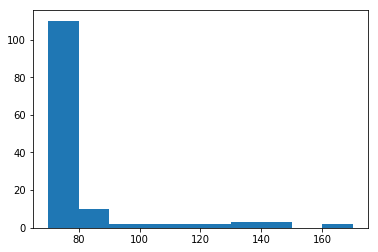

In [17]:
plt.hist(result_array_hardness)
plt.show()

Our assumpion was correct, nearly all values are around 60-80 with very less values about that threshold.